# Fake news classification (RU)


In [1]:
import pandas as pd
import numpy as np

np.random.seed(42)

## EDA

Посмотрим на данные, распределения, баланс классов

In [2]:
train_data = pd.read_csv('dataset/raw/train.tsv', sep='\t')
test_data = pd.read_csv('dataset/raw/test.tsv', sep='\t')

train_data.head()

,title,is_fake
0,Москвичу Владимиру Клутину пришёл счёт за вмеш...,1
1,Агент Кокорина назвал езду по встречке житейск...,0
2,Госдума рассмотрит возможность введения секрет...,1
3,ФАС заблокировала поставку скоростных трамваев...,0
4,Против Навального завели дело о недоносительст...,1


In [3]:
train_data['is_fake'].value_counts()

1    2879
0    2879
Name: is_fake, dtype: int64

Датасет сбалансирован, это очень хорошо, учитвая то, что наша ключевая метрика - F1

<AxesSubplot:>

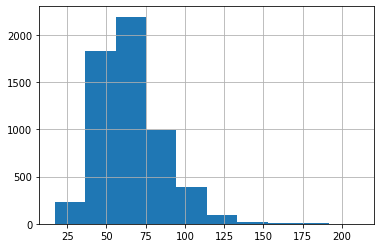

In [4]:
train_data['title'].str.len().hist()

Максимальная длина предложения нужна для некоторых моделей

In [5]:
MAX_SEQ_LENGTH = max(train_data['title'].str.len())
MAX_SEQ_LENGTH

211

## Data preprocessing


In [6]:
from sklearn.model_selection import train_test_split
import nltk

nltk.download('stopwords')

train_data = pd.read_csv('dataset/raw/train.tsv', sep='\t')
test_data = pd.read_csv('dataset/raw/test.tsv', sep='\t')

train_data.head()

[nltk_data] Downloading package stopwords to /home/danya-
[nltk_data]     sakharov/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


,title,is_fake
0,Москвичу Владимиру Клутину пришёл счёт за вмеш...,1
1,Агент Кокорина назвал езду по встречке житейск...,0
2,Госдума рассмотрит возможность введения секрет...,1
3,ФАС заблокировала поставку скоростных трамваев...,0
4,Против Навального завели дело о недоносительст...,1


In [7]:
! jupyter nbextension enable --py widgetsnbextension

Enabling notebook extension jupyter-js-widgets/extension...
      - Validating: OK


In [8]:
from preprocess import get_lemmas_from_text

train_data['lemmas'] = get_lemmas_from_text(train_data['title'])
test_data['lemmas'] = get_lemmas_from_text(test_data['title'])
train_data.head()

  0%|          | 0/5758 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

,title,is_fake,lemmas
0,Москвичу Владимиру Клутину пришёл счёт за вмеш...,1,москвич владимир клутин приходить счет вмешате...
1,Агент Кокорина назвал езду по встречке житейск...,0,агент кокорин называть езда встречок житейский...
2,Госдума рассмотрит возможность введения секрет...,1,госдума рассматривать возможность введение сек...
3,ФАС заблокировала поставку скоростных трамваев...,0,фас заблокировать поставка скоростной трамвай ...
4,Против Навального завели дело о недоносительст...,1,против навальный заводить дело недоносительств...


Посмотрим теперь на лемматизированные тексты и самые частотные слова в них 

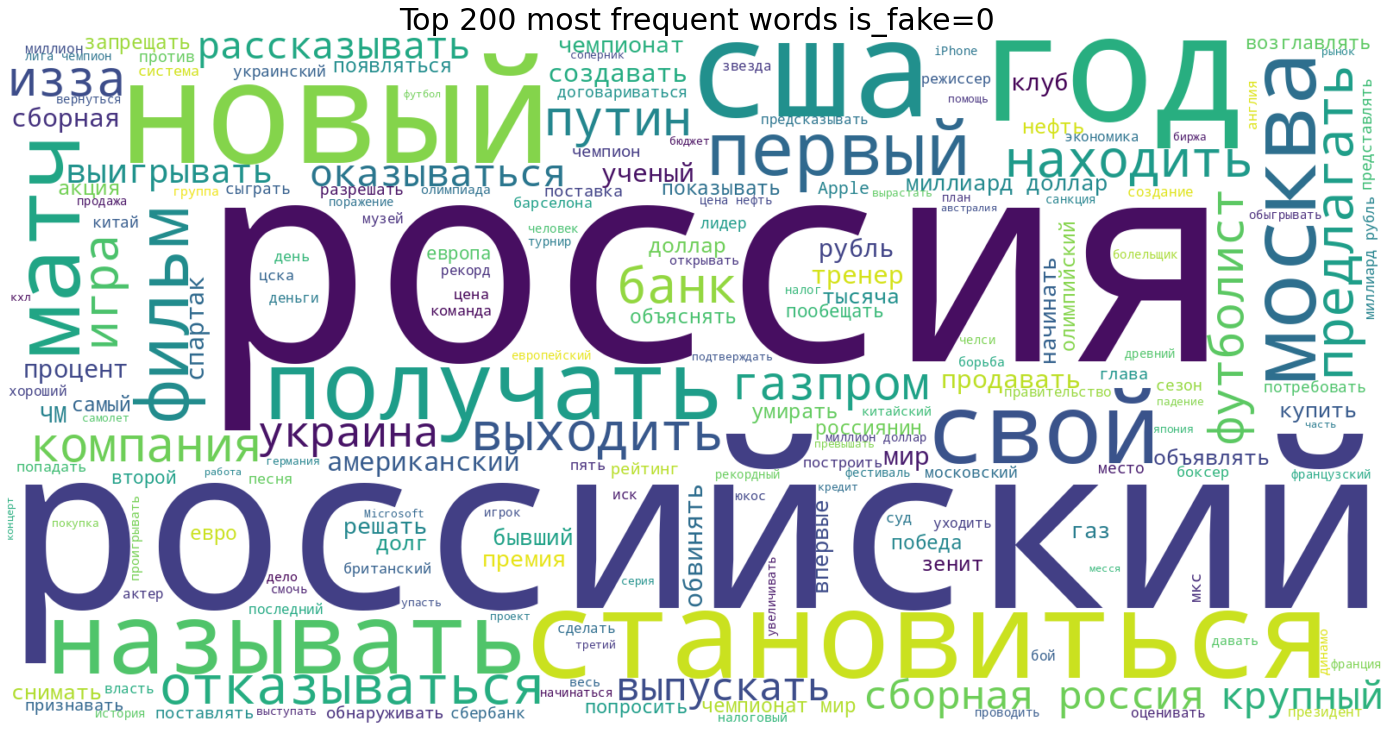

In [10]:
from visualize import get_wordcloud

get_wordcloud(train_data[train_data['is_fake']==0]['lemmas'], title='Top 200 most frequent words is_fake=0')

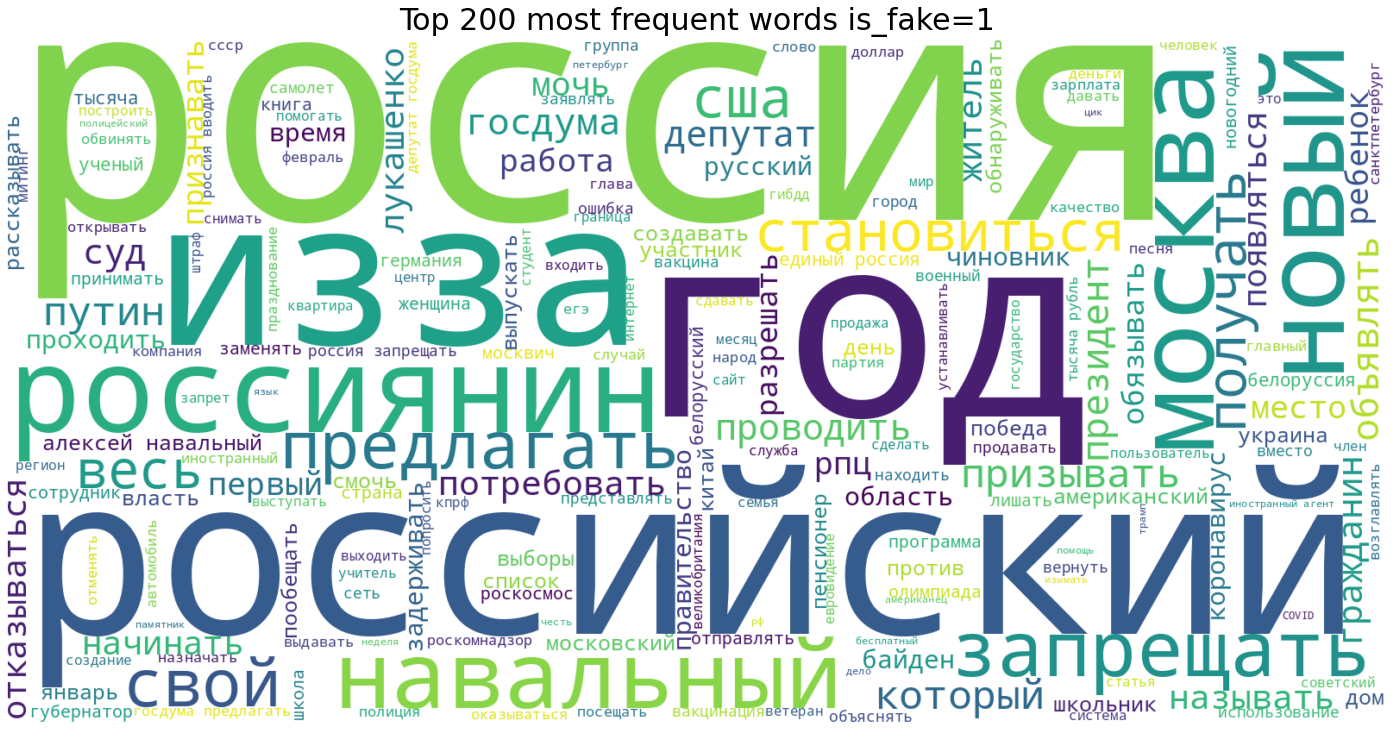

In [11]:
get_wordcloud(train_data[train_data['is_fake']==1]['lemmas'], title='Top 200 most frequent words is_fake=1')

К сожалению, самые частотные слова встречаются как в фейковых, так и настоящих новостях

Разобьем на train/val со стратификацией по таргету, чтобы поулчить сбалансированные классы

In [12]:
from sklearn.model_selection import train_test_split
train, val = train_test_split(train_data.drop('title',axis=1), test_size=0.2, random_state=42, stratify=train_data['is_fake'])

print("total train examples %s" % len(train))
print("total test examples %s\n" % len(val))
print(train['is_fake'].value_counts())

total train examples 4606
total test examples 1152

1    2303
0    2303
Name: is_fake, dtype: int64


In [13]:
preprocessed_path = "dataset/preprocessed"

if not os.path.exists(preprocessed_path):
    os.makedirs(preprocessed_path)
    
train.to_csv(preprocessed_path + '/train.csv')
val.to_csv(preprocessed_path + '/val.csv')
test_data.to_csv(preprocessed_path + '/test.csv')

## Modelling

In [15]:
import torch
from sklearn.metrics import classification_report

task_type = "GPU" if torch.cuda.is_available() else "CPU"

### PAC

In [16]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import PassiveAggressiveClassifier

tfidf = TfidfVectorizer()
vec_train = tfidf.fit_transform(train['lemmas'])
vec_val = tfidf.transform(val['lemmas'])

pac = PassiveAggressiveClassifier(C = 0.01)

pac.fit(vec_train, train['is_fake'])
val_pred = pac.predict(vec_val)


print(classification_report(val['is_fake'], val_pred))

              precision    recall  f1-score   support

           0       0.85      0.85      0.85       576
           1       0.85      0.85      0.85       576

    accuracy                           0.85      1152
   macro avg       0.85      0.85      0.85      1152
weighted avg       0.85      0.85      0.85      1152



Неплохой результат для первой примененной модели, посмотрим на другие

### Fasttext baseline


In [17]:
import fasttext

In [20]:
#Write data to file for fasttext classifier 
fasttext_path = "dataset/fasttext"

if not os.path.exists(fasttext_path):
    os.makedirs(fasttext_path)

with open(fasttext_path + '/data.train.txt', 'w+') as outfile:
    for x, y in zip(train['lemmas'], train['is_fake']):
        outfile.write('__label__' + str(y) + ' ' + x + '\n')


with open(fasttext_path + '/test.txt', 'w+') as outfile:
    for x, y in zip(val['lemmas'], val['is_fake']):
        outfile.write('__label__' + str(y) + ' ' + x + '\n')

In [23]:
classifier = fasttext.train_supervised(fasttext_path + '/data.train.txt', lr=1.0, epoch=25, wordNgrams=3)
    
num, precision, recall = classifier.test(fasttext_path + '/test.txt')

print(f'Precision: {precision:.5f}')
print(f'Recall: {recall:.5f}')
print('Number of examples:', num)

Read 0M words
Number of words:  9437
Number of labels: 2


Precision: 0.86198
Recall: 0.86198
Number of examples: 1152


Progress: 100.0% words/sec/thread:  545125 lr:  0.000000 avg.loss:  0.031678 ETA:   0h 0m 0s


Тоже неплохой результат, слегка лучше **PAC**

### CatBoost

In [24]:
from catboost import Pool, CatBoostClassifier

train_pool = Pool(data=
    train.drop(['is_fake'], axis=1), 
    label=train['is_fake'],
    text_features = ['lemmas']
)

valid_pool = Pool(data=
    val.drop(['is_fake'], axis=1), 
    label=val['is_fake'],
    text_features=['lemmas']
)

model = CatBoostClassifier(verbose=500, use_best_model=True, task_type=task_type)
model.fit(train_pool, eval_set=valid_pool)

Learning rate set to 0.062538
0:	learn: 0.6590950	test: 0.6522286	best: 0.6522286 (0)	total: 23.9ms	remaining: 23.9s
500:	learn: 0.3251543	test: 0.3572292	best: 0.3559229 (260)	total: 21s	remaining: 20.9s
999:	learn: 0.2927684	test: 0.3609633	best: 0.3559229 (260)	total: 42.2s	remaining: 0us
bestTest = 0.3559229109
bestIteration = 260
Shrink model to first 261 iterations.


In [26]:
pred = model.predict(val.drop(['is_fake'], axis=1))
print(classification_report(val['is_fake'],pred))

              precision    recall  f1-score   support

           0       0.83      0.87      0.85       576
           1       0.86      0.83      0.85       576

    accuracy                           0.85      1152
   macro avg       0.85      0.85      0.85      1152
weighted avg       0.85      0.85      0.85      1152



**Catboost** в среднем показывает аналогичные результаты (из коробки)

### CatBoost + Optuna

Попробуем подобрать гиперпараметры с помощью **optuna**

In [27]:
import optuna
from utils import CB_objective
from functools import partial

In [28]:
optuna.logging.set_verbosity(0)
study = optuna.create_study(direction="maximize")
study.optimize(partial(CB_objective, task_type=task_type, train_pool=train_pool,
               valid_pool=valid_pool, val=val), n_trials=50, timeout=600, n_jobs=1)

In [17]:
study.best_params

{'depth': 13,
 'boosting_type': 'Plain',
 'bootstrap_type': 'MVS',
 'learning_rate': 0.08,
 'l2_leaf_reg': 0.2494718345819619}

In [18]:
model = CatBoostClassifier(**study.best_params, use_best_model=True, verbose=500, task_type=task_type)
model.fit(train_pool, eval_set=valid_pool)
pred = model.predict(val.drop(['is_fake'], axis=1))
print(classification_report(val['is_fake'],pred))

0:	learn: 0.6407924	test: 0.6293740	best: 0.6293740 (0)	total: 327ms	remaining: 5m 26s
500:	learn: 0.1293011	test: 0.3517248	best: 0.3423119 (257)	total: 2m 31s	remaining: 2m 30s
999:	learn: 0.0575841	test: 0.3785409	best: 0.3423119 (257)	total: 5m 1s	remaining: 0us
bestTest = 0.3423119121
bestIteration = 257
Shrink model to first 258 iterations.
              precision    recall  f1-score   support

           0       0.85      0.89      0.87       576
           1       0.89      0.85      0.87       576

    accuracy                           0.87      1152
   macro avg       0.87      0.87      0.87      1152
weighted avg       0.87      0.87      0.87      1152



Отличный результат, побили предыдущие модели

### RuBERT


Попробуем предобученный RuBERT с DeepPavlov

In [29]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [34]:
from transformers import AutoTokenizer

TOKENIZER_NAME = "DeepPavlov/rubert-base-cased"
MODEL_NAME = "DeepPavlov/rubert-base-cased"
SAVED_MODEL_NAME = MODEL_NAME.split("/", 1)[1]
BATCH_SIZE = 16

tokenizer = AutoTokenizer.from_pretrained(TOKENIZER_NAME)

In [14]:
from preprocess import convert_examples_to_inputs
from preprocess import get_data_loader

train_features = convert_examples_to_inputs(
    train['lemmas'], train['is_fake'], MAX_SEQ_LENGTH, tokenizer)
val_features = convert_examples_to_inputs(
    val['lemmas'], val['is_fake'], MAX_SEQ_LENGTH, tokenizer)

train_dataloader = get_data_loader(train_features, BATCH_SIZE, shuffle=True)
val_dataloader = get_data_loader(val_features, BATCH_SIZE, shuffle=False)

In [15]:
from transformers.models.bert.modeling_bert import BertForSequenceClassification

model = BertForSequenceClassification.from_pretrained(MODEL_NAME)
out_features = model.bert.encoder.layer[1].output.dense.out_features
model.classifier = torch.nn.Linear(out_features, 2)

Some weights of the model checkpoint at DeepPavlov/rubert-base-cased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.predictions.decoder.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were n

In [18]:
from transformers.optimization import get_linear_schedule_with_warmup
from torch.optim import AdamW

GRADIENT_ACCUMULATION_STEPS = 1
NUM_TRAIN_EPOCHS = 10
LEARNING_RATE = 1e-5
WARMUP_PROPORTION = 0.1
MAX_GRAD_NORM = 5
OUTPUT_DIR = "trained_models/"
PATIENCE = 4

model.to(device)

num_train_steps = int(len(train_dataloader.dataset) /
                      BATCH_SIZE / GRADIENT_ACCUMULATION_STEPS * NUM_TRAIN_EPOCHS)
                      
num_warmup_steps = int(WARMUP_PROPORTION * num_train_steps)

param_optimizer = list(model.named_parameters())

no_decay = ['bias', 'LayerNorm.bias', 'LayerNorm.weight']

optimizer_grouped_parameters = [
    {'params': [p for n, p in param_optimizer if not any(
        nd in n for nd in no_decay)], 'weight_decay': 0.01},
    {'params': [p for n, p in param_optimizer if any(
        nd in n for nd in no_decay)], 'weight_decay': 0.0}
]

optimizer = AdamW(optimizer_grouped_parameters, lr=LEARNING_RATE)
scheduler = get_linear_schedule_with_warmup(
    optimizer, num_warmup_steps=num_warmup_steps, num_training_steps=num_train_steps)
loss_fn = torch.nn.CrossEntropyLoss()

In [19]:
import torch
import os
from model import train_model

loss_history = []
acc_history = []
no_improvement = 0

config = (int(NUM_TRAIN_EPOCHS), GRADIENT_ACCUMULATION_STEPS, MAX_GRAD_NORM, SAVED_MODEL_NAME)
train_model(device, model, train_dataloader, val_dataloader, loss_fn, optimizer, scheduler, config)

Epoch:   0%|          | 0/10 [00:00<?, ?it/s]

Training iteration:   0%|          | 0/288 [00:00<?, ?it/s]

Evaluation iteration:   0%|          | 0/72 [00:00<?, ?it/s]

Loss history: []
Dev loss: 0.013611948117613792
Dev accuracy: 0.8611111111111112
New record, model saved


Epoch:  10%|█         | 1/10 [01:53<17:05, 113.94s/it]

Training iteration:   0%|          | 0/288 [00:00<?, ?it/s]

Evaluation iteration:   0%|          | 0/72 [00:00<?, ?it/s]

Loss history: [0.013611948117613792]
Dev loss: 0.012288901954889297
Dev accuracy: 0.8923611111111112
New record, model saved


Epoch:  20%|██        | 2/10 [03:48<15:15, 114.42s/it]

Training iteration:   0%|          | 0/288 [00:00<?, ?it/s]

Evaluation iteration:   0%|          | 0/72 [00:00<?, ?it/s]

Loss history: [0.013611948117613792, 0.012288901954889297]
Dev loss: 0.013921565376222134
Dev accuracy: 0.9079861111111112
New record, model saved


Epoch:  30%|███       | 3/10 [05:43<13:21, 114.54s/it]

Training iteration:   0%|          | 0/288 [00:00<?, ?it/s]

Evaluation iteration:   0%|          | 0/72 [00:00<?, ?it/s]

Epoch:  40%|████      | 4/10 [07:29<11:08, 111.35s/it]

Loss history: [0.013611948117613792, 0.012288901954889297, 0.013921565376222134]
Dev loss: 0.023115526884794235
Dev accuracy: 0.9010416666666666


Training iteration:   0%|          | 0/288 [00:00<?, ?it/s]

Evaluation iteration:   0%|          | 0/72 [00:00<?, ?it/s]

Epoch:  50%|█████     | 5/10 [09:16<09:08, 109.78s/it]

Loss history: [0.012288901954889297, 0.013921565376222134, 0.023115526884794235]
Dev loss: 0.02591642364859581
Dev accuracy: 0.8949652777777778


Training iteration:   0%|          | 0/288 [00:00<?, ?it/s]

Evaluation iteration:   0%|          | 0/72 [00:00<?, ?it/s]

Epoch:  60%|██████    | 6/10 [11:03<07:15, 108.82s/it]

Loss history: [0.013921565376222134, 0.023115526884794235, 0.02591642364859581]
Dev loss: 0.03229236602783203
Dev accuracy: 0.9010416666666666


Training iteration:   0%|          | 0/288 [00:00<?, ?it/s]

Evaluation iteration:   0%|          | 0/72 [00:00<?, ?it/s]

Epoch:  70%|███████   | 7/10 [12:50<05:24, 108.22s/it]

Loss history: [0.023115526884794235, 0.02591642364859581, 0.03229236602783203]
Dev loss: 0.03725181892514229
Dev accuracy: 0.8975694444444444


Training iteration:   0%|          | 0/288 [00:00<?, ?it/s]

Evaluation iteration:   0%|          | 0/72 [00:00<?, ?it/s]

Epoch:  80%|████████  | 8/10 [14:37<03:35, 107.76s/it]

Loss history: [0.02591642364859581, 0.03229236602783203, 0.03725181892514229]
Dev loss: 0.03610224276781082
Dev accuracy: 0.9027777777777778


Training iteration:   0%|          | 0/288 [00:00<?, ?it/s]

Evaluation iteration:   0%|          | 0/72 [00:00<?, ?it/s]

Epoch:  90%|█████████ | 9/10 [16:24<01:47, 107.40s/it]

Loss history: [0.03229236602783203, 0.03725181892514229, 0.03610224276781082]
Dev loss: 0.03883161395788193
Dev accuracy: 0.9071180555555556


Training iteration:   0%|          | 0/288 [00:00<?, ?it/s]

Evaluation iteration:   0%|          | 0/72 [00:00<?, ?it/s]

Epoch: 100%|██████████| 10/10 [18:10<00:00, 109.07s/it]

Loss history: [0.03725181892514229, 0.03610224276781082, 0.03883161395788193]
Dev loss: 0.03614262118935585
Dev accuracy: 0.8993055555555556


In [20]:
from utils import val_report

model_state_dict = torch.load(os.path.join(OUTPUT_DIR, SAVED_MODEL_NAME), map_location=lambda storage, loc: storage)
model = BertForSequenceClassification.from_pretrained(MODEL_NAME, state_dict=model_state_dict)

dev_correct, dev_predicted = val_report(device, model, train_dataloader, val_dataloader, loss_fn)

Evaluation iteration:   0%|          | 0/288 [00:00<?, ?it/s]

Evaluation iteration:   0%|          | 0/72 [00:00<?, ?it/s]

Training performance: (0.9811115935735997, 0.9811115935735997, 0.9811115935735997, None)
Development performance: (0.9079861111111112, 0.9079861111111112, 0.9079861111111112, None)
              precision    recall  f1-score   support

           0       0.91      0.90      0.91       576
           1       0.90      0.91      0.91       576

    accuracy                           0.91      1152
   macro avg       0.91      0.91      0.91      1152
weighted avg       0.91      0.91      0.91      1152



## Test inference (BERT)

In [21]:
from model import evaluate

test_features = convert_examples_to_inputs(test_data['lemmas'], test_data['is_fake'], MAX_SEQ_LENGTH, tokenizer)
test_dataloader = get_data_loader(test_features, BATCH_SIZE, shuffle=False)

_, _, predicted_labels = evaluate(device, model, test_dataloader, loss_fn)

Evaluation iteration:   0%|          | 0/63 [00:00<?, ?it/s]

In [22]:
prediction = pd.DataFrame({'title':test_data['title'], 'is_fake':pd.Series(predicted_labels)})
prediction.to_csv('prediction.csv', sep='\t', index=False)